# **ML 09**  
**┗ 신용카드 사기 거래 예측**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「의미있는 변수 선택」
* 🥈Session 2 - 「사기 거래 특성 파악」
* 🥇Session 3 - 「ML 활용 사기 거래 예측」

In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir('/content/drive/MyDrive/데이터분석/파이썬_실습/ML 실습/ML실습/ML실습/9_신용카드 사기 거래 예측')
os.getcwd()

'/content/drive/MyDrive/데이터분석/파이썬_실습/ML 실습/ML실습/ML실습/9_신용카드 사기 거래 예측'

## **문제상황 및 데이터 살펴보기**
---
> **시나리오** 💳😠 (서비스 운영자, Risk management, 이상거래탐지)

```
카드사 A는 최근 비트코인 열풍으로 수수료 거래 금액이 늘어 좋으면서도  한 편으로 골치를 썩고 있다. 비트코인 결제를 신용카드로 결제하여 많은  
수수료를 얻어가고 있지만, 그만큼 사기거래가 발생하고 처리해달라는 고객 Claim이 수도 없이 쏟아지기 때문이다. 이에 카드사는 사기거래로  
예측되는 거래건에 경우 거래를 제한하고자 한다.
```  

> **데이터 살펴보기**

* 거래 기준 Spending data
* 데이터 명세 ⬇

|account_age_days| transaction_amt| transaction_adj_amt|historic_velocity|ip_address|user_agent|
|:---:|:---:|:---:|:---:|:---:|:---:|
|계좌 생성후 지난일|거래금액|거래 조정 금액|과거 거래금액|IP주소|사용환경|
|email_domain|phone_number|billing_city|billing_postal|billing_state|card_bin|
|email 도메인|전화번호|청구도시|청구우편번호|청구주|카드bin번호(앞6자리)|
|currency|cvv|signature_image|transaction_type|transaction_env|EVENT_TIMESTAMP|applicant_name|
|통화|CVV|서명이미지|거래종류|거래환경|거래일자|
billing_address|merchant_id|locale|tranaction_initiate|days_since_last_logon|inital_amount|
|청구주소|상점ID|지역|거래초기코드|마지막로그인후경과일|초기잔액|
|EVENT_LABEL|
|사기여부|

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('9_credit_fraud.csv')
df.head(5)

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,...,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...,perez-garza.com,878-111-5140,Woodsburgh,96336.0,...,X,2020-12-29 09:05:51,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,legit
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera/9.76.(X11; Linux i686; mi-NZ) Presto/2.9...,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,...,W,2021-06-22 18:05:06,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,legit
2,6987.0,2892.0,61.0,5007.0,166.245.194.83,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.6.20) G...,davis-calderon.com,(983)585-2863x652,Lorichester,83236.0,...,X,2021-05-10 13:48:38,Sarah Gray,4948 Lisa Passage,086-41-1624,dv_MV,T,83.0,7412.0,legit
3,2712.0,3040.0,28.0,6022.0,100.1.217.216,Mozilla/5.0 (Macintosh; Intel Mac OS X 10 9_3 ...,rose-lee.org,+1-678-897-3420x60738,Stephenmouth,78364.0,...,N,2021-03-11 07:36:40,Valerie Jenkins,1616 Little Camp,669-97-4021,byn_ER,M,24.0,4623.0,legit
4,3598.0,2976.0,66.0,2600.0,113.156.65.245,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.5.20) G...,nash.net,(013)204-1766x92641,New Brianmouth,77499.0,...,G,2021-03-27 06:13:35,Amy Coleman,149 Harris Rapid,088-21-6329,the_NP,K,21.0,1905.0,legit



## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 사기거래로 인한 고객 Claim 증가, 브랜드 이미지 감소, 고객 탈퇴
```  

> **기대효과**

```
▶ 사기거래 거래 제한으로 고객 Claim 감소, 브랜드 이미지 회복, 고객 방어
```

> **해결방안**

```
▶ 카드 Spending data 활용 사기거래 예측
▶ Session 1 🥉
 - Data 전처리와 의미있는 변수에 대해 고민해보고 탐색
▶ Session 2 🥈
 - Numeric(연속형, 숫자형) 변수와 Categorical(범주형) 변수에 대해 탐색
▶ Session 3 🥇
 - ML 알고리즘을 활용하여 사기거래 예측
```

> **성과측정**  

```
▶ 모델 적용 전/후 사기거래 Claim 감소 건수
```

> **현업적용**  

```
▶ 카드 Spending data 실시간 수집
▶ 거래 발생시 마다 모든 거래 Data 모델 Input 후 사기거래의심 건수 추출
▶ 사기 가능성 높은 거래 건수에 대해서 제한조치 실행
```

> **주요 코드 미리 살펴보기**

```
▶ session 1 → split, apply(lamda x:), list.append
▶ session 2 → np.where, reset_index(), sns.distplot, sns.catplot
▶ session 3 → train_test_split, classification_report, roc_auc_score
```


## **🥉Session 1**  
**┗ 의미있는 변수 선택**  
---

### · Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인

  (2) Data type 확인

  (3) Null값 확인 (※ 빈 값의 Data)

  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)  


In [ ]:
# ▶ Data 형태 확인
# ▶ 150,000  row, 26 col로 구성됨
print('df', df.shape)

df (150000, 26)


In [ ]:
# ▶ Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   account_age_days       149892 non-null  float64
 1   transaction_amt        149870 non-null  float64
 2   transaction_adj_amt    149886 non-null  float64
 3   historic_velocity      149885 non-null  float64
 4   ip_address             149873 non-null  object 
 5   user_agent             149887 non-null  object 
 6   email_domain           149910 non-null  object 
 7   phone_number           149873 non-null  object 
 8   billing_city           149884 non-null  object 
 9   billing_postal         149876 non-null  float64
 10  billing_state          149887 non-null  object 
 11  card_bin               149872 non-null  float64
 12  currency               149892 non-null  object 
 13  cvv                    149877 non-null  object 
 14  signature_image        149895 non-nu

In [ ]:
# ▶ Null 값 확인
print(df.isnull().sum())

account_age_days         108
transaction_amt          130
transaction_adj_amt      114
historic_velocity        115
ip_address               127
user_agent               113
email_domain              90
phone_number             127
billing_city             116
billing_postal           124
billing_state            113
card_bin                 128
currency                 108
cvv                      123
signature_image          105
transaction_type         116
transaction_env          123
EVENT_TIMESTAMP          112
applicant_name           143
billing_address          134
merchant_id              107
locale                   134
tranaction_initiate      126
days_since_last_logon    136
inital_amount            128
EVENT_LABEL                0
dtype: int64


In [ ]:
# ▶ 결측치 행 모두 제거 (※ 결측치 데이터가 작아서 일괄 drop)
#df = df.dropna(subset = [''], axis = 0)
df = df.dropna(axis = 0)
df.describe()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,billing_postal,card_bin,days_since_last_logon,inital_amount
count,147000.000000,147000.000000,147000.000000,147000.000000,147000.000000,147000.000000,147000.000000,147000.000000
mean,4645.817224,2521.343592,54.208837,4702.388673,50179.458129,41834.312320,49.858524,7996.856367
std,1153.792072,604.680167,10.068128,1188.255402,28389.219411,10082.094148,29.208844,4047.922681
min,1.000000,5.000000,1.000000,50.000000,503.000000,6040.000000,0.000000,1000.000000
25%,3824.000000,2103.000000,48.000000,3872.000000,25298.000000,35386.000000,24.000000,4485.000000
50%,4668.000000,2543.000000,55.000000,4729.000000,50072.000000,42086.000000,50.000000,7999.000000
75%,5476.000000,2951.000000,61.000000,5548.000000,74346.000000,47373.000000,75.000000,11495.000000
max,9119.000000,4999.000000,99.000000,9999.000000,99950.000000,67639.000000,100.000000,15000.000000


In [ ]:
#split를 사용하기 전에 형태 확인
print(df['user_agent'].head(1))

0    Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...
Name: user_agent, dtype: object


In [ ]:
# Series나 데이터프레임 컬럼에는 직접 split이 안됨
 #lamda를 활용해야 함
df_copy = df.copy()
df_copy['user_agent'] = df_copy['user_agent'].split('/')
df_copy

AttributeError: ignored

In [ ]:
# ▶ user_agent 중에서 브라우저 name 선택
    #[0] 선택
df_copy['user_agent'] = df_copy['user_agent'].apply(lambda x: x.split('/')[0])
df_copy['user_agent'].value_counts()

Mozilla    111613
Opera       35387
Name: user_agent, dtype: int64

In [ ]:
df_copy['EVENT_LABEL'].value_counts()

legit    138996
fraud      8004
Name: EVENT_LABEL, dtype: int64

In [ ]:
# ▶ 5% 사기거래률
(df_copy[df_copy['EVENT_LABEL'] == 'fraud']['EVENT_LABEL'].count()
/ (df_copy[df_copy['EVENT_LABEL'] == 'legit']['EVENT_LABEL'].count() + df_copy[df_copy['EVENT_LABEL'] == 'fraud']['EVENT_LABEL'].count()) ) * 100

5.444897959183673

### · 의미있는 변수 선택  
---

* Numeric 변수
  - 연속형 변수는 구간화를 통해 범주형 변수로 변경하고, *잘 구분* 되어지는지 확인   
  (※ 평균 사기거래률 대비 그룹핑한 그룹의 사기거래율이 차이가 나는 것)
  
* Categorical 변수
  - 각 그룹별 예측하고자 하는 데이터가 잘 나눠지는지 확인  
  (※ 각 그룹마다 사기거래율의 차이가 나는 것)


In [ ]:
# ▶ 하나의 Col에 대한 데이터 타입 확인
 # 알파벳 O가 object 데이터
df_copy['ip_address'].dtypes

dtype('O')

In [ ]:
# ▶ numeric, categorical value 나누기
categorical_list = []
numeric_list = []

for i in df.columns:
    if df[i].dtypes == 'O':
        categorical_list.append(i)
    else:
        numeric_list.append(i)

print("categoical_list :", categorical_list)
print("numeric_list :", numeric_list)

categoical_list : ['ip_address', 'user_agent', 'email_domain', 'phone_number', 'billing_city', 'billing_state', 'currency', 'cvv', 'signature_image', 'transaction_type', 'transaction_env', 'EVENT_TIMESTAMP', 'applicant_name', 'billing_address', 'merchant_id', 'locale', 'tranaction_initiate', 'EVENT_LABEL']
numeric_list : ['account_age_days', 'transaction_amt', 'transaction_adj_amt', 'historic_velocity', 'billing_postal', 'card_bin', 'days_since_last_logon', 'inital_amount']


## **🥈Session 2**  
**┗ 사기 거래 특성 파악**  
---

### · Numeric 변수
---

In [ ]:
df_copy[numeric_list]

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,billing_postal,card_bin,days_since_last_logon,inital_amount
0,3371.0,2167.0,56.0,2572.0,96336.0,40771.0,59.0,13646.0
1,2714.0,2045.0,48.0,4517.0,78083.0,24480.0,0.0,11930.0
2,6987.0,2892.0,61.0,5007.0,83236.0,37778.0,83.0,7412.0
3,2712.0,3040.0,28.0,6022.0,78364.0,55790.0,24.0,4623.0
4,3598.0,2976.0,66.0,2600.0,77499.0,37370.0,21.0,1905.0
...,...,...,...,...,...,...,...,...
149995,3986.0,2890.0,57.0,4544.0,34817.0,30017.0,99.0,6681.0
149996,5834.0,1875.0,61.0,4369.0,35879.0,65507.0,85.0,2402.0
149997,4781.0,3371.0,48.0,5135.0,84167.0,47079.0,22.0,4113.0
149998,6085.0,2306.0,59.0,4846.0,80391.0,25891.0,70.0,4531.0


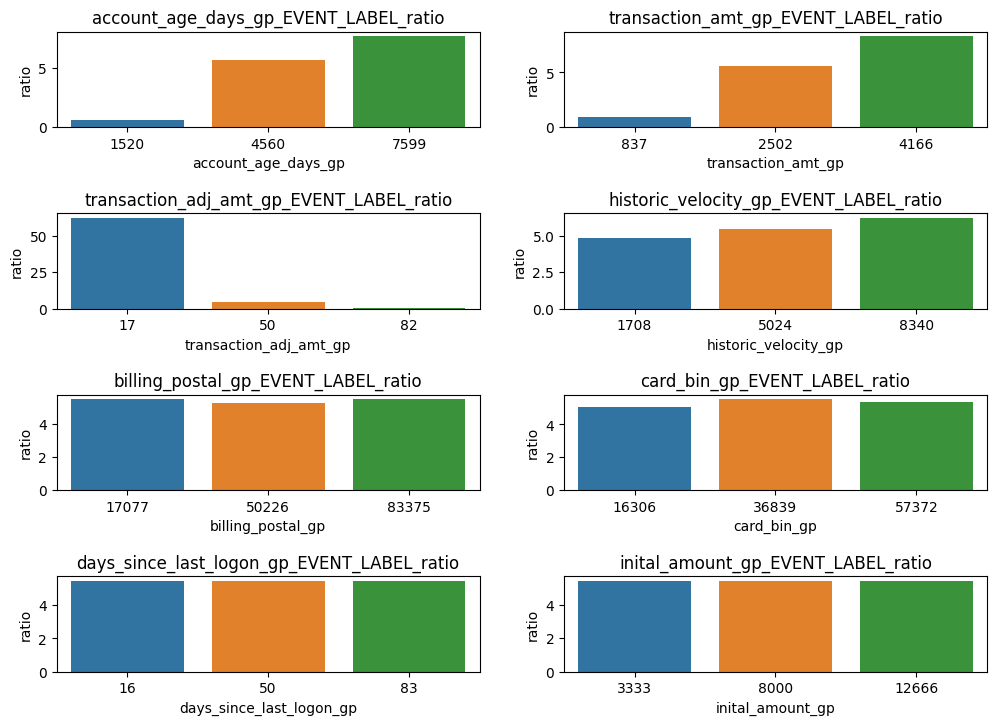

In [ ]:
#numeric_list 기준으로 범주화 및 범주 별 차이 시각화
 #account_age_days와 transaction_amt에 따라 ratio가 선형적으로 변화한다는 것 발견 (그룹간 유의미한 차이)


# for i, columns in enumerate(numeric_list):
#     bins = np.linspace(df_copy[columns].min(), df_copy[columns].max(), num = 4)
#     labels = [f"{int(bins[i] + bins[i+1])/2})" for i in range(len(bins) - 1)]
#     new_columns = f"{columns}_gp"
#     df_copy[new_columns] = pd.cut(df_copy[columns], bins = bins, labels = labels, include_lowest = True)

#     df_copy_gp = pd.DataFrame(df_copy.groupby([new_columns, 'EVENT_LABEL'])['EVENT_TIMESTAMP'].count()).reset_index()

#     sns.catplot(data= df_copy_gp, x = new_columns, hue = 'EVENT_LABEL')
#     plt.title(f"{new_columns}_EVENT_LABEL")

fig, axes = plt.subplots(4, 2, figsize=(12, 8))

for i, columns in enumerate(numeric_list):
    bins = np.linspace(df_copy[columns].min(), df_copy[columns].max(), num = 4)
    labels = [f"{int((bins[i] + bins[i+1])/2)}" for i in range(len(bins) - 1)]
    new_columns = f"{columns}_gp"
    df_copy[new_columns] = pd.cut(df_copy[columns], bins = bins, labels = labels, include_lowest = True)

    df_numeric_gp = pd.DataFrame(df_copy.groupby([new_columns, 'EVENT_LABEL'])['EVENT_TIMESTAMP'].count()).reset_index()
    df_numeric_gp_pivot = pd.pivot_table(df_numeric_gp,
                                   index = new_columns,
                                   columns = 'EVENT_LABEL',
                                   values = 'EVENT_TIMESTAMP').reset_index()
    df_numeric_gp_pivot.columns.names = ['']
    df_numeric_gp_pivot['ratio'] = round((df_numeric_gp_pivot.iloc[:,1]
                                          / (df_numeric_gp_pivot.iloc[:,1] + df_numeric_gp_pivot.iloc[:,2]))*100, 2)
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.barplot(data=df_numeric_gp_pivot, x=new_columns, y='ratio', ax=ax)
    ax.set_title(f"{new_columns}_EVENT_LABEL_ratio")
plt.subplots_adjust(bottom = 0.1, top = 0.9, hspace = 0.9)
plt.show()


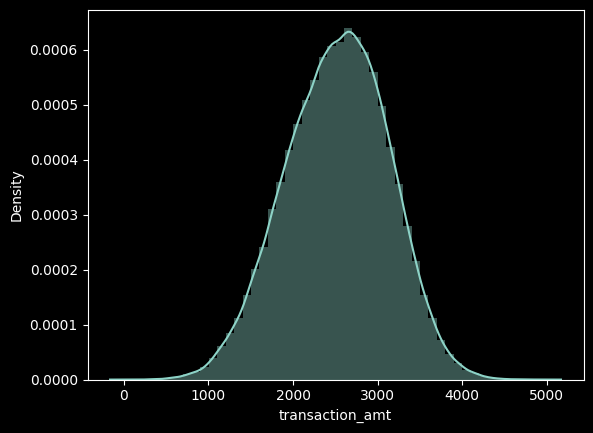

In [ ]:
# ▶ transaction_amt(거래 금액)에 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

sns.distplot(df_copy['transaction_amt']);

In [ ]:
# ▶ numeric 변수를 수동으로 구간화해서 정말로 transaction_amt가 유의미한 변수인지 2차 검증
 #transaction_amt_gp 값이 클수록 ratio 증가 확인
import numpy as np
df_copy['transaction_amt_gp'] = np.where (df_copy['transaction_amt'] <= 2000, 1,
                           np.where(df_copy['transaction_amt'] <= 3000, 2, 3))
df_tran = pd.DataFrame(df_copy.groupby(['transaction_amt_gp', 'EVENT_LABEL'])['EVENT_TIMESTAMP'].count()).reset_index()

df_pivot = pd.pivot_table(df_tran, index = 'transaction_amt_gp',
                          columns = 'EVENT_LABEL',
                          values = 'EVENT_TIMESTAMP').reset_index()
df_pivot.columns.names = ['']
df_pivot['ratio'] = round(df_pivot.iloc[:,1] / (df_pivot.iloc[:, 1] + df_pivot.iloc[:, 2])*100,2)
df_pivot.sort_values(by = ['ratio'],ascending = False)

,transaction_amt_gp,fraud,legit,ratio
2,3,2826,29988,8.61
1,2,4825,79588,5.72
0,1,353,29420,1.19


### · Categorical 변수
---

In [ ]:
df_copy[categorical_list].head(2)

,ip_address,user_agent,email_domain,phone_number,billing_city,billing_state,currency,cvv,signature_image,transaction_type,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,EVENT_LABEL
0,154.68.49.124,Opera,perez-garza.com,878-111-5140,Woodsburgh,California,cad,D,F,U,X,2020-12-29 09:05:51,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,legit
1,39.131.125.85,Opera,mcneil-ortega.com,(002)736-0139,West Kevin,Florida,cad,X,X,H,W,2021-06-22 18:05:06,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,legit


In [ ]:
categorical_list

['ip_address',
 'user_agent',
 'email_domain',
 'phone_number',
 'billing_city',
 'billing_state',
 'currency',
 'cvv',
 'signature_image',
 'transaction_type',
 'transaction_env',
 'EVENT_TIMESTAMP',
 'applicant_name',
 'billing_address',
 'merchant_id',
 'locale',
 'tranaction_initiate',
 'EVENT_LABEL']

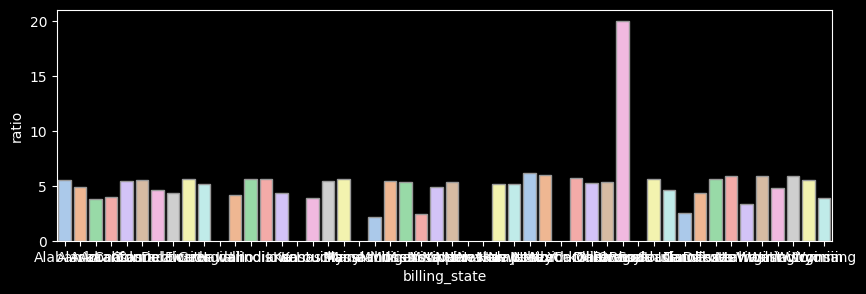

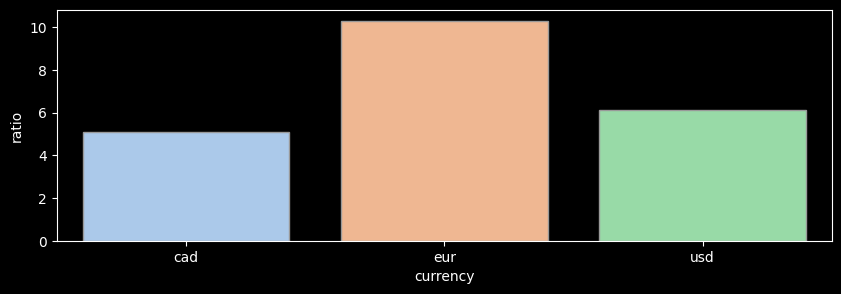

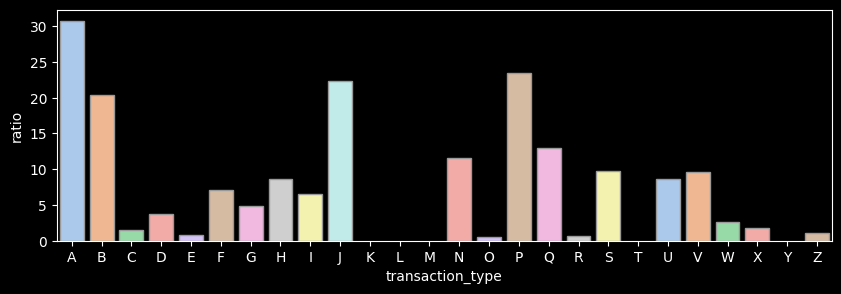

In [ ]:
categorical_list_check = ['billing_state', 'currency',
                         'transaction_type']

for columns in categorical_list_check:
    df_tran = pd.DataFrame(df_copy.groupby([columns, 'EVENT_LABEL'])['EVENT_TIMESTAMP'].count()).reset_index()

    df_pivot = pd.pivot_table(df_tran,
                       index = columns,
                       columns = 'EVENT_LABEL',
                       values = 'EVENT_TIMESTAMP')

    df_pivot = df_pivot.reset_index()
    df_pivot.columns.names=['']

    df_pivot['ratio'] =   round((df_pivot.iloc[:,1] / (df_pivot.iloc[:,1] + df_pivot.iloc[:,2])) * 100,1)
    sns.barplot(data = df_pivot, x = columns, y = 'ratio', palette = 'pastel', edgecolor = '.6')
    plt.gcf().set_size_inches(10,3)
    plt.show()

   billing_state  fraud  legit  ratio
36        Oregon    1.0    4.0   20.0


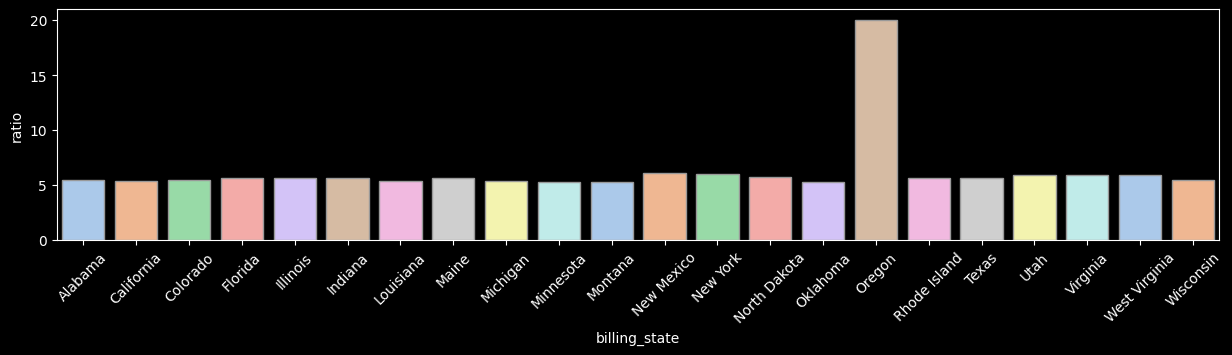

In [ ]:
#Oregon 지역의 사기율 거래율이 높음
 #하지만 표본이 5
df_billing_gp = pd.DataFrame(df_copy.groupby(['billing_state','EVENT_LABEL'])['EVENT_TIMESTAMP'].count()).reset_index()
df_billing_gp = pd.pivot_table(df_billing_gp, index = 'billing_state',
                               columns = 'EVENT_LABEL',
                               values = 'EVENT_TIMESTAMP').reset_index()
df_billing_gp.columns.names=['']
df_billing_gp['ratio'] = round((df_billing_gp.iloc[:,1] / (df_billing_gp.iloc[:,1] + df_billing_gp.iloc[:,2])) * 100,1)

check = df_billing_gp[df_billing_gp['ratio'] >= df_billing_gp['ratio'].mean()]

sns.barplot(data = check, x = 'billing_state', y = 'ratio', palette = 'pastel', edgecolor = '.6')
plt.xticks(rotation = 45)
plt.gcf().set_size_inches(15,3)
print(check[check['billing_state'] == 'Oregon'])
plt.show()

4306


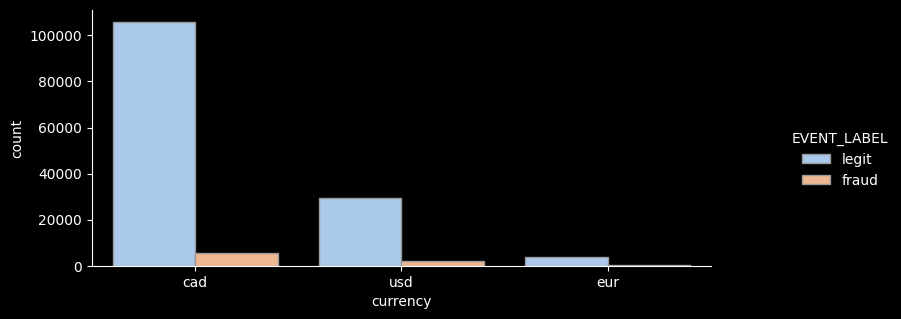

In [ ]:
# ▶ currency(거래 통화)에 따른 사기거래율 비교
 #위 그래프와 합쳐서 생각하면 유로로 결제하면 ration는 높음, 하지만 표본이 너무 적음
print(df_copy[df_copy['currency'] == 'eur']['EVENT_TIMESTAMP'].count())
sns.catplot(x="currency", hue="EVENT_LABEL", kind="count",palette="pastel", edgecolor=".6",data=df_copy);
plt.gcf().set_size_inches(10, 3)
plt.show()

## **🥇Session 3**  
**┗ ML 활용 사기 거래 예측**  
---

### · 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature와 예측하고자하는 값인 Y로 데이터를 나눔
* 학습과 예측을 위한 Train / Test set 분할

In [ ]:
df.head(5)

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,...,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL,transaction_amt_gp
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera,perez-garza.com,878-111-5140,Woodsburgh,96336.0,...,2020-12-29 09:05:51,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,legit,2
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,...,2021-06-22 18:05:06,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,legit,2
2,6987.0,2892.0,61.0,5007.0,166.245.194.83,Mozilla,davis-calderon.com,(983)585-2863x652,Lorichester,83236.0,...,2021-05-10 13:48:38,Sarah Gray,4948 Lisa Passage,086-41-1624,dv_MV,T,83.0,7412.0,legit,3
3,2712.0,3040.0,28.0,6022.0,100.1.217.216,Mozilla,rose-lee.org,+1-678-897-3420x60738,Stephenmouth,78364.0,...,2021-03-11 07:36:40,Valerie Jenkins,1616 Little Camp,669-97-4021,byn_ER,M,24.0,4623.0,legit,1
4,3598.0,2976.0,66.0,2600.0,113.156.65.245,Mozilla,nash.net,(013)204-1766x92641,New Brianmouth,77499.0,...,2021-03-27 06:13:35,Amy Coleman,149 Harris Rapid,088-21-6329,the_NP,K,21.0,1905.0,legit,3


In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147000 entries, 0 to 149999
Data columns (total 34 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   account_age_days          147000 non-null  float64 
 1   transaction_amt           147000 non-null  float64 
 2   transaction_adj_amt       147000 non-null  float64 
 3   historic_velocity         147000 non-null  float64 
 4   ip_address                147000 non-null  object  
 5   user_agent                147000 non-null  object  
 6   email_domain              147000 non-null  object  
 7   phone_number              147000 non-null  object  
 8   billing_city              147000 non-null  object  
 9   billing_postal            147000 non-null  float64 
 10  billing_state             147000 non-null  object  
 11  card_bin                  147000 non-null  float64 
 12  currency                  147000 non-null  object  
 13  cvv                       147

In [ ]:
# ▶ Train/Test data에는 문자(str)형태로 이루어진 데이터를 Input 할 수 없음
# ▶ Model에서 이해할 수 있는 1, 0으로 Target Data를 변경
import numpy as np
df_copy['EVENT_LABEL']=np.where(df_copy['EVENT_LABEL']=='fraud', 1, 0)
df_copy['EVENT_LABEL'].value_counts()

0    138996
1      8004
Name: EVENT_LABEL, dtype: int64

In [ ]:
# ▶ 모델링을 학습하기 위한 Feature(X)와 Y데이터를 구분하는 단계
 # 시각화를 위해 만들었던 gp는 제외하기 위해 df_copy가 아닌 df로 진행
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X=df.drop(['EVENT_TIMESTAMP','EVENT_LABEL'], axis=1)
Y=df['EVENT_LABEL']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(102900, 24)
(102900,)
(44100, 24)
(44100,)


In [ ]:
# ▶ Label encoding이전 범주형 변수 리스트 확인
print(categorical_list)

['ip_address', 'user_agent', 'email_domain', 'phone_number', 'billing_city', 'billing_state', 'currency', 'cvv', 'signature_image', 'transaction_type', 'transaction_env', 'EVENT_TIMESTAMP', 'applicant_name', 'billing_address', 'merchant_id', 'locale', 'tranaction_initiate', 'EVENT_LABEL']


In [ ]:
# ▶ 사용하지 않을 카테고리형 변수는 리스트에서 제외
categorical_list.remove('EVENT_LABEL')
categorical_list.remove('EVENT_TIMESTAMP')

In [ ]:
categorical_list

['ip_address',
 'user_agent',
 'email_domain',
 'phone_number',
 'billing_city',
 'billing_state',
 'currency',
 'cvv',
 'signature_image',
 'transaction_type',
 'transaction_env',
 'applicant_name',
 'billing_address',
 'merchant_id',
 'locale',
 'tranaction_initiate']

In [ ]:
# ▶ Categorical(범주형) 변수는 One-hot-encoding or Label-encoding을 통해 숫자형 변수로 변경해야함
# ▶ One-hot-encoding은 차원이 많은 변수에는 불리, Label-encoding은 회귀관련 알고리즘에서는 사용 어려움.(※Tree 계열 알고리즘에서는 사용 가능)
 #회귀관련 알고리즘은 숫자의 크고 작음에 따라 결과값이 달라지는데, Label-encoding을 할 경우 컴퓨터가 임의로 (보통 데이터 배열 순서로) 숫자 지정
  #즉, 회귀관련 알고리즘에서는 사용이 어려움
  #Label-encoding은 train 데이터에 없는 값이 test에 나오면 오류가 날 수 있는 문제가 있음
   #이를 해결하기 위해 train과 test 데이터 모두를 통해 fit을 진행해야 함
from sklearn.preprocessing import LabelEncoder

for col in categorical_list:
    print(col)
    le = LabelEncoder()
    le.fit(list(x_train[col].values) + list(x_test[col].values))                #list 형태로 만들어서 진행
    x_train[col] = le.transform(x_train[col])
    x_test[col] = le.transform(x_test[col])

ip_address
user_agent
email_domain
phone_number
billing_city
billing_state
currency
cvv
signature_image
transaction_type
transaction_env
applicant_name
billing_address
merchant_id
locale
tranaction_initiate


In [ ]:
x_train[categorical_list].head(3)

,ip_address,user_agent,email_domain,phone_number,billing_city,billing_state,currency,cvv,signature_image,transaction_type,transaction_env,applicant_name,billing_address,merchant_id,locale,tranaction_initiate
11334,8580,672,2920,428,8801,30,0,2,7,22,2,22595,41392,79598,154,2
17812,12381,5607,5150,3817,8094,4,2,23,21,23,25,70593,96294,7111,47,22
30819,7285,3955,1094,10223,2049,5,2,7,7,8,8,80557,28885,69838,244,24


In [ ]:
x_test[categorical_list].head(3)

,ip_address,user_agent,email_domain,phone_number,billing_city,billing_state,currency,cvv,signature_image,transaction_type,transaction_env,applicant_name,billing_address,merchant_id,locale,tranaction_initiate
148359,11150,7534,4248,9660,7318,49,0,6,7,8,3,39566,9935,50748,186,7
143579,4628,1104,1943,6201,8646,42,0,3,6,3,22,43017,101429,54593,172,9
149090,6872,2724,205,6784,1969,22,0,23,20,3,5,34316,109639,38007,36,2


### · 모델 학습 및 평가
---
* 모델을 학습하고 예측을 수행하여 성능을 평가

In [ ]:
# ▶ 학습
from sklearn.metrics import classification_report

#보통 max_depth = 6~8, n_estimators=400~600 으로 진행
 #max_depth를 높일 수록 과적합될 확률이 높음
rfc = RandomForestClassifier(random_state = 123456, max_depth=8, n_estimators=500)
rfc.fit(x_train, y_train)

# ▶ 예측
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     97297
           1       0.97      0.34      0.50      5603

    accuracy                           0.96    102900
   macro avg       0.97      0.67      0.74    102900
weighted avg       0.96      0.96      0.95    102900

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41699
           1       0.96      0.31      0.47      2401

    accuracy                           0.96     44100
   macro avg       0.96      0.65      0.72     44100
weighted avg       0.96      0.96      0.95     44100



In [ ]:
pd.Series(y_pred_test).value_counts()

0    43323
1      777
dtype: int64

In [ ]:
# ▶ ROC: 이진 분류기의 성능을 평가할때 사용하는 지표(metric), 100에 가까울 수록 모델 성능이 좋은 것 (※ 다양한 threshold에 대한 이진분류기의 성능을 한번에 표시한 것)
# ▶ 과적합 문제, Train과 Test set에 성능을 최대한 줄여주는 것이 과적합을 방지
from sklearn.metrics import roc_auc_score

y_pred_train_proba = rfc.predict_proba(x_train)[:, 1]                           # 0번째에는 0이 나올 확률, 1번째에는 1이 나올 확률이 출력되기 때문
y_pred_test_proba = rfc.predict_proba(x_test)[:, 1]


roc_score_train = roc_auc_score(y_train, y_pred_train_proba)
roc_score_test = roc_auc_score(y_test, y_pred_test_proba)

print("roc_score_train :", roc_score_train)
print("roc_score_test :", roc_score_test)

roc_score_train : 0.9481051494023376
roc_score_test : 0.9320753234598655


### · 중요 변수 파악
---
* Feature IMP 분석을 통한 중요변수 파악

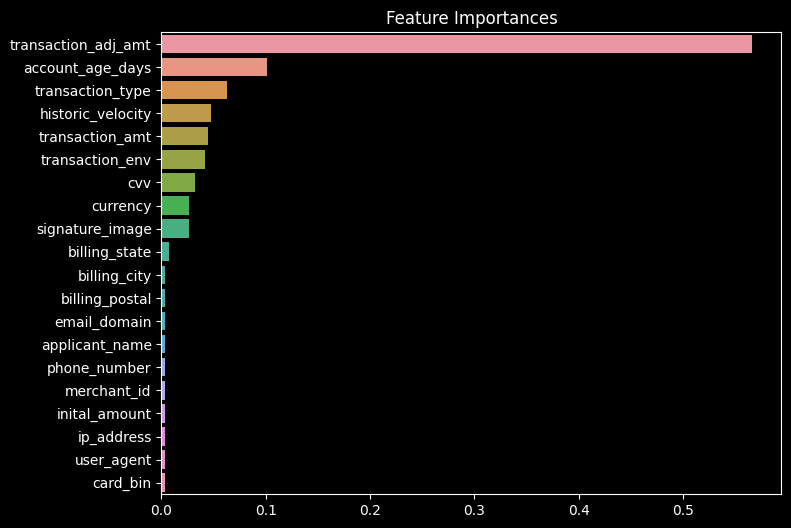

In [ ]:
#아래처럼 중요도가 너무 낮은 애들은 나중에는 없에고 진행하기도 함
#위에서 확인한 것처럼 transaction_adj_amt와 account_age_days가 중요한 것을 알 수 있음

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
# plt.rc('xtick', labelsize=5)
plt.show()


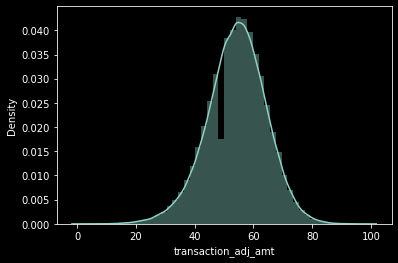

In [ ]:
# ▶ 중요변수 1번에 대한 추가 탐색

sns.distplot(df['transaction_adj_amt']);

In [ ]:
# ▶ 구간화
import numpy as np
df['transaction_adj_amt_gp'] = np.where (df['transaction_adj_amt'] <= 40, 1,
                           np.where(df['transaction_adj_amt'] <= 60, 2, 3))

df[['transaction_adj_amt','transaction_adj_amt_gp']]

,transaction_adj_amt,transaction_adj_amt_gp
0,56.0,2
1,48.0,2
2,61.0,3
3,28.0,1
4,66.0,3
...,...,...
149995,57.0,2
149996,61.0,3
149997,48.0,2
149998,59.0,2


In [ ]:
df.groupby(['transaction_adj_amt_gp', 'EVENT_LABEL'])['EVENT_TIMESTAMP'].count()

transaction_adj_amt_gp  EVENT_LABEL
1                       0               8072
                        1               4628
2                       0              92394
                        1               3131
3                       0              38530
                        1                245
Name: EVENT_TIMESTAMP, dtype: int64

In [ ]:
# ▶ 조정된 금액이 작을수록 사기거래 확률이 급격시 상승한다. (※ Critical한 변수).
print("gp1 :", (4628 / (4628+8072)) * 100)
print("gp2 :", (3131 / (3131+92394)) * 100)
print("gp3 :", (245 / (245+38530)) * 100)

gp1 : 36.44094488188976
gp2 : 3.277676001046846
gp3 : 0.6318504190844616



### · 모델 Save and Read
---
* 최종 모델을 저장 및 다시 불러오기

In [ ]:
import pickle
# 모델 저장
saved_model = pickle.dumps(rfc)

# 모델 Read
clf_from_pickle = pickle.loads(saved_model)

#변수명명=clf_from_pickle.predic('데이터프레임')